In [4]:
import sinter

from qldpc import codes
from qldpc.objects import Pauli, PauliXZ
from qldpc.stim.circuit import memory_experiment
from qldpc.stim.noise_model import NoiseModel
from qldpc.stim.sinter_decoders import SinterDecoder
from qldpc.stim.syndrome_measurement import BareColorCircuit

### Toric Code Memory Experiments

In [5]:
def run_experiments(basis: PauliXZ, d_range: list[int], p_range: list[float]):
    sm_compiler = BareColorCircuit()
    tasks: list[sinter.Task] = []
    for d in d_range:
        ring_code = codes.RingCode(d)
        toric_code = codes.HGPCode(ring_code, ring_code)
        for p in p_range:
            noise_model = NoiseModel.uniform_depolarizing(p, idling_error=False)
            tasks.append(
                sinter.Task(
                    circuit=memory_experiment(toric_code, noise_model, sm_compiler, d, basis),
                    json_metadata={"d": d, "p": p},
                )
            )

    return sinter.collect(
        num_workers=4,
        max_shots=10**6,
        max_errors=100,
        tasks=tasks,
        decoders=["bplsd"],
        custom_decoders={
            "bplsd": SinterDecoder(
                basis,
                with_BP_LSD=True,
                max_iter=30,
                bp_method="ms",
                lsd_method="lsd_cs",
                lsd_order=0,
            )
        },
    )

In [6]:
d_range = [3, 5, 7]
p_range = [1e-3, 3e-3, 5e-3, 7e-3, 1e-2]
z_basis_results = run_experiments(Pauli.Z, d_range, p_range)
x_basis_results = run_experiments(Pauli.X, d_range, p_range)

#### Plotting

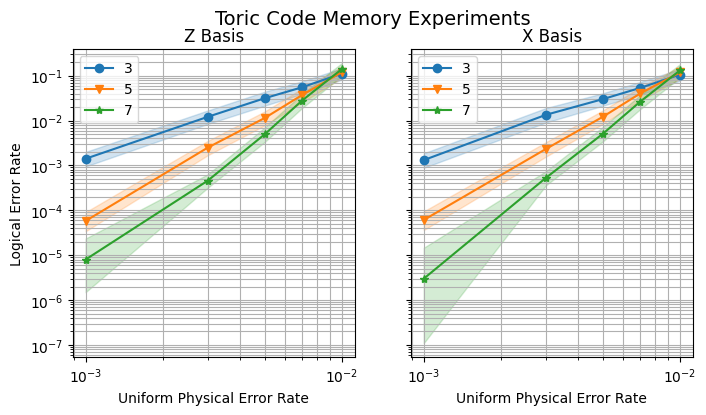

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
sinter.plot_error_rate(
    ax=ax[0],
    stats=z_basis_results,
    x_func=lambda stats: stats.json_metadata["p"],
    group_func=lambda stats: stats.json_metadata["d"],
)
ax[0].loglog()
ax[0].grid(which="both")
ax[0].legend()
ax[0].set_ylabel("Logical Error Rate")
ax[0].set_xlabel("Uniform Physical Error Rate")
ax[0].set_title("Z Basis")

sinter.plot_error_rate(
    ax=ax[1],
    stats=x_basis_results,
    x_func=lambda stats: stats.json_metadata["p"],
    group_func=lambda stats: stats.json_metadata["d"],
)
ax[1].loglog()
ax[1].grid(which="both")
ax[1].legend()
ax[1].set_xlabel("Uniform Physical Error Rate")
ax[1].set_title("X Basis")

plt.suptitle("Toric Code Memory Experiments", fontsize=14)
plt.show()